<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is provided as a starting point to help you generate random instances G1 and G2 as mentioned in the handout.

You are free to use and modify it at your own convenience.

---



In [1]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
class DatasetGenerator(object):
    def __init__(self, N=100):
        self.N = N
        self.x = None
        self.v = None
        self.refresh()
  
    def refresh(self):
        raise Exception("undefined")

In [3]:
class G1(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = st.uniform().rvs((self.N,))

In [4]:
class G2(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

### Uniform distribution ($\mathcal U([0,1])$) 

In [5]:
g1 = G1()

Examples:

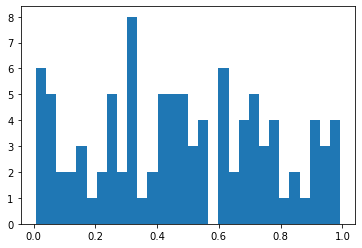

In [6]:
# Plot a histogram of the v array
plt.hist(g1.v, bins=30)
plt.show()

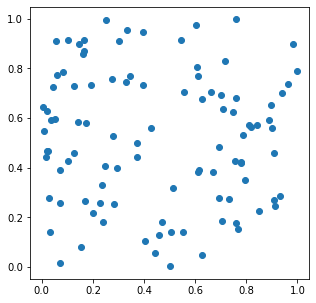

In [7]:
# plot the position of the points
plt.figure(figsize=(5,5))
plt.scatter(g1.x[:,0], g1.x[:,1])
plt.show()

You can refresh the dataset

In [8]:
g1.refresh() # generate a new dataset

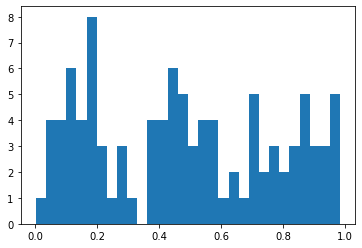

In [9]:
plt.hist(g1.v, bins=30)
plt.show()

Or for instance, you can generate 10 instances and compute the average position of all the points:

In [10]:
m = np.array([0., 0.])

for _ in range(10):
    g1.refresh() # refresh the dataset
    m  += 0.1*g1.x.mean()

print(m)

[0.50069015 0.50069015]


### Test on log-normal distribution

In [11]:
g2 = G2()

Example:

you can use g2 to generate an instance of the lognormal distribution

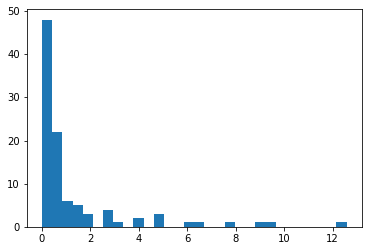

In [12]:
plt.hist(g2.v, bins=30)
plt.show()

In [13]:
g2.refresh() # to generate a new x and v

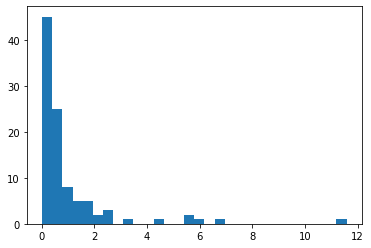

In [14]:
plt.hist(g2.v, bins=30)
plt.show()

---

### Metropolis Hastings

In [15]:
# fill-in this section with your code

In [16]:
def compute_distance_matrix(points):
    '''
    Returns the matrix of pairwise squared distances between the given points.

            Parameters:
                    points (matrix (N, 2)): An array of 2d points

            Returns:
                    pairwise_distances (matrix (N, N)): The matrix of pairwise distances
    '''
    N = len(points)
    p1 = points.reshape(1, N, 2)
    p2 = points.reshape(N, 1, 2)
    return np.sum(np.square(p1 - p2), axis=2)

In [17]:
def f(data, _lambda, selected_cities, cache):
    '''
    Evaluate the function for the selected cities
            
            Parameters:
                    data (DatasetGenerator): The cities dataset
                    _lambda (float): The lambda parameter
                    selected_cities (array (N,)): The cities that are in the subset
                    cache (matrix (N, N)): The matrix of pairwise distances

            Returns:
                    The output of the function (float): The output of the function for the given cities
    '''
    sel = selected_cities.reshape((data.N, 1)) @ selected_cities.reshape((1, data.N))
    max_squared_dist = np.max(cache[sel])
    return np.sum(data.v[selected_cities]) - _lambda * data.N * np.pi * max_squared_dist / 4

In [18]:
def Metropolis_Hasting_step(data, _lambda, cache, selection, scores, remove_duplicates=True, tol=0):
    '''
    Perform one iteration of the Metropolis-Hastings algorithm
            
            Parameters:
                    data (DatasetGenerator): The cities dataset
                    _lambda (float): The lambda parameter
                    cache (matrix (N, N)): The matrix of pairwise distances
                    selection (matrix (batch_size, N)): The selected cities for all the chains
                    scores (array (batch_size,)): The scores
                    remove_duplicates (bool) : Merge the chains that are in the same state (Default : True)
                    tol (float): The tolerance to accept a move (Default : 0)

            Returns:
                    The output of the function (float): The output of the function for the given cities
    '''
    batch_size = len(selection)
    #Generate random moves for all the chains
    ind = np.random.randint(0,data.N, batch_size)
    #Convert values to a one-hot encoding
    mask = np.zeros((batch_size, data.N))
    mask[np.arange(batch_size), ind] = 1
    #cast the matrix to boolean
    mask = np.array(mask, dtype = "bool")
    #create all the proposal moves
    proposal = selection ^ mask
    #iterate over all chains
    for i in range(len(selection)):
        #get the proposal for the current chain
        prop = proposal[i]
        #if at least one city is selected
        if (np.sum(prop) > 0):
            #get the old score
            old_score = scores[i]
            #compute the new score
            score = f(data, _lambda, prop, cache)
            #if the move is accepted
            if score >= old_score - tol :
                #update the score and the selection
                scores[i] = score
                selection[i] = prop
    if remove_duplicates:
        #remove the duplicate chains and the associated scores
        selection, ids = np.unique(selection, return_index=True, axis=0)
        scores = scores[ids]    
    return selection, scores

In [19]:
def is_local_max(data, _lambda, cache, selection_line, score, tol=0):
    '''
    Check whether the chain is at a local maximum or not
    This function is quite slow
            
            Parameters:
                    data (DatasetGenerator): The cities dataset
                    _lambda (float): The lambda parameter
                    cache (matrix (N, N)): The matrix of pairwise distances
                    selection_line (array (N,)): The selected cities
                    scores (float): The current score
                    tol (float): The tolerance to accept a move (Default : 0)

            Returns:
                    new_selection (matrix (<batch_size, N)): The reduced selection matrix
                    new_scores (array (<batch_size,)): The reduced scores
    '''
    #allocate a mask
    mask = np.zeros(data.N, dtype="bool")
    #iterate all the cities
    for i in range(data.N):
        #generate a proposal
        mask[i] = True
        proposal = selection_line ^ mask
        #if at least one city is selected
        if (np.sum(proposal) > 0):
            #compute the new_score
            new_score = f(data, _lambda, proposal, cache)
            #if improvement is possible, it is not a local maximum
            if new_score >= score - tol:
                return False
        #clear the mask
        mask[i] = False
    #if we did not return yet, it is a local maximum
    return True

In [20]:
def remove_local_max(data, _lambda, cache, selection, scores, tol=0):
    '''
    Remove the chains that are in a local maximums and would reject all moves, except the best one
    This function is quite slow
            
            Parameters:
                    data (DatasetGenerator): The cities dataset
                    _lambda (float): The lambda parameter
                    cache (matrix (N, N)): The matrix of pairwise distances
                    selection (matrix (batch_size, N)): The selected cities for all the chains
                    scores (array (batch_size,)): The scores
                    tol (float): The tolerance to accept a move (Default : 0)

            Returns:
                    new_selection (matrix (<batch_size, N)): The reduced selection matrix
                    new_scores (array (<batch_size,)): The reduced scores
    '''
    #keep track of the lines to remove
    useless_lines = []
    #get the indice of the best chain
    best_chain = np.argmax(scores)
    #iterate over all chains
    for i in range(len(selection)):
        #check whether the chain is stuck or not
        is_useful = not is_local_max(data, _lambda, cache, selection[i], scores[i], data, tol=tol)
        if not (is_useful or (i == best_chain)):
            useless_lines.append(i)
    #remove the useless lines
    selection = np.delete(selection, useless_lines, axis=0)
    scores = np.delete(scores, useless_lines, axis=0)
    return selection, scores

In [21]:
def drop_half(selection, scores):
    '''
    Drop all the chains whose score is strictly below the median
            
            Parameters:
                    selection (matrix (batch_size, N)): The selected cities for all the chains
                    scores (array (batch_size,)): The scores

            Returns:
                    new_selection (matrix (ceil(batch_size / 2), N)): The reduced selection matrix
                    new_scores (array (ceil(batch_size / 2),)): The reduced scores
    '''
    #We keep at least one chain
    if len(scores) <= 1 :
        return selection, scores
    else :
        where = np.where(np.median(scores) <= scores)
        return selection[where], scores[where]

In [22]:
def Metropolis_Hasting(data, _lambda, cache=None, init_selection=None, plot=False, verbose_progress=False, display_result=False, batch_size=100, max_iter=1000, init_tol=0):
    '''
    Perform the Metropolis-Hastings algorithm
            
            Parameters:
                    data (DatasetGenerator): The cities dataset
                    _lambda (float): The lambda parameter
                    cache (matrix (N,N)) : The pairwise squared distance matrix (will be computed if not given) (Default : None)
                    init_selection (matrix (batch_size, N)): The starting points of the chains (Default : None, random sets containing a single city)
                    plot (bool): Display the evolution of the best score and the best selection (Default : False)
                    verbose_progress (bool): Print what the algorithm is doing
                    display_result (bool): Print the results of the algorithm (Default : False)
                    batch_size (int): The number of chains we emulate; Not used if init_selection not None (Default : 100)
                    max_iter (int): What is the number of M-H steps (Default : 1000) 
                    init_tol (float): The first value of the tolerance to accept a move (decreases over time and reaches 0 at 75% of max_iter) (Default : 0)

            Returns:
                    best_selection (array (N,)): The best state ever reached
                    best_score (float): The best_score ever reached
    '''
    
    #compute cache
    if verbose_progress :
            print("Computing the cache matrix...", end="\r")
    if cache is None:
        cache = compute_distance_matrix(data.x)
    
    if verbose_progress :
        print("Initializing...", end="\r")
    #initialize the selection
    if init_selection is not None :
        selection = init_selection
    else :
        #Generate random city numbers
        ind = np.random.randint(0, data.N, batch_size)
        #Convert values to a one-hot encoding
        selection = np.zeros((batch_size, data.N))
        selection[np.arange(batch_size), ind] = 1
        #cast the matrix to boolean
        selection = np.array(selection, dtype="bool")
    #initialize the score array
    scores = np.array([f(data, _lambda, selection[i], cache) for i in range(len(selection))])
    #the best score so far
    best_score = np.max(scores)
    #the best scores (over all chains) at each step
    best_scores = []
    #the iteration when the overall best was reached
    time_best_reached = 0
    #the best combination of cities
    best_selection = selection[np.argmax(scores)]
    #initialize the tolerance
    t = init_tol
    
    
    #run the algorith max_iter times
    for i in range(max_iter):
        #compute a step of the algorithm
        if verbose_progress : 
            print("Current iteration : {} Progress : {:.2f}%".format(i + 1, (i + 1) / max_iter * 100), end="\r")
        selection, scores = Metropolis_Hasting_step(data, _lambda, cache, selection, scores, remove_duplicates=False, tol=t)
        
        #compute the best current score
        best = np.max(scores)
        #if there is an improvement store the new values
        if best > best_score:
            best_score = best
            time_best_reached = i
            best_selection = np.copy(selection[np.argmax(scores)])
        #keep track of the best scores
        best_scores.append(best)
        
        #update the tolerance
        t = max(t - init_tol / (0.6 * max_iter), 0)
    if verbose_progress :
        print()
    if (display_result):
        loc_max = is_local_max(data, _lambda, cache, best_selection, best_score)
        print()
        print("Score : {}".format(best_score))
        print("Number of cities : {}".format(np.sum(best_selection)))
        print("Batch size : {}".format(len(scores)))
        print("Number of iterations until finding the best score = {}".format(time_best_reached))
        print("Is the best selection a local max : {}".format(loc_max))
    if (plot):
        plt.figure(figsize=(5,5))
        plt.plot(np.arange(len(best_scores)), best_scores, c="g")
        plt.title("Evolution of the score")
        plt.xlabel("#iteration")
        plt.ylabel("Best Score")
        plt.show()
        plt.figure(figsize=(5,5))
        plt.scatter(data.x[:,0], data.x[:,1], c="r")
        plt.scatter(data.x[best_selection,0], data.x[best_selection,1], c="g")
        plt.show()
    return best_selection, np.max(np.array(best_scores))

In [23]:
np.random.seed(36)
g = G1(100000)
l = 0.6

#### The functions below are some approximations and optimizations to solve the problem faster

In [24]:
class Dataset(object):
    """Dataset that allows to choose x and v"""
    def __init__(self, N, x, v):
        self.N = N
        self.x = x
        self.v = v

In [25]:
def max_squared_dist2(points):
    '''
    Computes the square of the maxium distance among the given points
            
            Parameters:
                    points (matrix (N, 2)): array of 2d points

            Returns:
                    max_dist (float): The maximum distance
    '''
    N = len(points)
    p1 = points.reshape(1, N, 2)
    p2 = points.reshape(N, 1, 2)
    return np.max(np.sum(np.square(p1 - p2), axis = 2))

def f2(_lambda, x, v, N):
    '''
    Alternvative way to compute f that does not require a cache
            
            Parameters:
                    _lambda (float): The lambda parameter
                    x (matrix (number_selected_cities,2)): The positions of the selected cities
                    v (array (number_selected_cities,2)): The populations of the selected cities
                    N (int): The total number of cities

            Returns:
                    result (float): The value of the function
    '''
    return np.sum(v) - _lambda * N * np.pi * max_squared_dist2(x) / 4

In [26]:
def aggregate_data(data, quantity=10, min_coord=np.zeros(2), max_coord=np.ones(2)):
    '''
    Aggregates the cities into agglomeration, there will be quantity**2 aglomerations in total
            
            Parameters:
                    data (DatasetGenerator): The cities dataset
                    quantity (int) : The number of agglomeration along the two axis (Default: 10)
                    min_coord (array (2,)): The bottom left corner of the area (Default: [0,0]))
                    max_coord (array (2,)): The upper right corner of the area (Default: [1,1]))

            Returns:
                    agg_data (Dataset): The reduced dataset
                    cluster_assign (array (data.N,)): A map to reconstruct the original dataset
    '''
    n_clusters = quantity**2
    grid_size = (max_coord - min_coord) / quantity
    #Compute the position of the agglomerations
    agg_x = [[grid_size[0] * (0.5 + i // quantity), grid_size[1] * (0.5 + i % quantity)] for i in range(n_clusters)]
    #Each agglomeration's population is zero at the beginning
    agg_v = [0 for i in range(n_clusters)]
    cluster_assign = []
    for i in range(data.N):
        #Compute the agglomeartion in which the city i should go
        r, c = (((data.x[i] - min_coord) / max_coord) * n_clusters) // quantity
        cluster = int(quantity * r + c)
        #Add the population to the right cluster
        agg_v[cluster] += data.v[i]
        #Keep track of the assignations
        cluster_assign.append(cluster)
    #Create the new dataset
    agg_data = Dataset(n_clusters, np.array(agg_x), np.array(agg_v))
    return agg_data, np.array(cluster_assign)

In [27]:
def retrieve_selection(cluster_assign, agg_selection):
    '''
    Retrieve the selection of cities for the dataset (data) from a selection over the agglomerated one (agg)
            
            Parameters:
                    cluster_assign (array (data.N,)): A map to reconstruct the original dataset
                    agg_selection (array (agg.N,)): The selection of the agglomerated dataset
                    min_coord (array (2,)): The bottom left corner of the area (Default: [0,0]))
                    max_coord (array (2,)): The upper right corner of the area (Default: [1,1]))

            Returns:
                    selection (array (data.N,)): The cities selected for the larger dataset
    '''
    return agg_selection[cluster_assign]

In [28]:
def MH_Clustering(data, _lambda, size=2, min_coord=np.zeros(2), max_coord=np.ones(2)):
    '''
    Run the MH algorithm over cells of a grid of side size, then use the results as starting points 
    for chains over the entire dataset
            
            Parameters:
                    data (Dataset/DatasetGenerator): The cities dataset
                    _lambda (float): The lambda parameter
                    size (int): The side of the grid

            Returns:
                    selection (array (data.N,)): The cities selected
    '''
    n_clusters = size**2
    #initialize the clusers
    clusters_x = [[] for i in range(n_clusters)]
    clusters_v = [[] for i in range(n_clusters)]
    clusters_N = [0 for i in range(n_clusters)]
    cluster_assign = []
    for i in range(data.N):
        #assign the city i to the right cluster
        r, c = (((data.x[i] - min_coord) / max_coord) * n_clusters) // size
        cluster = int(size * r + c)
        clusters_x[cluster].append(data.x[i])
        clusters_v[cluster].append(data.v[i])
        #keep track of the assignations
        cluster_assign.append((cluster, clusters_N[cluster]))
        clusters_N[cluster] += 1
    #Store the best chains for the next part
    best_selections = []
    bests = []
    for i in range(n_clusters):
        print("Cluster {} :".format(i))
        #Create a new dataset
        cluster_data = Dataset(clusters_N[i], np.array(clusters_x[i]), np.array(clusters_v[i]))
        #Run the MH algorithm over the cluster, with a correct lambda to have a consistent result
        best_selection, best = Metropolis_Hasting(cluster_data, _lambda * data.N / cluster_data.N, plot=False, verbose_progress=True, display_result=False, batch_size=50, max_iter=cluster_data.N * 10, init_tol=2.5)
        bests.append(best)
        best_selections.append(best_selection)
    #Increase the size of the selections to fit the original dataset
    init_sel = np.zeros((n_clusters, data.N), dtype="bool")
    for i, c in enumerate(cluster_assign):
        init_sel[c[0],i] = best_selections[c[0]][c[1]]
    #Run the algorithm starting from the cluster maximums
    best_selection, best = Metropolis_Hasting(data, _lambda,init_selection=init_sel, plot=False, verbose_progress=True, display_result=False, max_iter=data.N * 3, init_tol=0)
    return best_selection, best

In [29]:
def add_cities(data, best_selection):
    '''
    Add as many cities as possible in order increase the score
    (Note: Removing some cities may further improve the score)
            
            Parameters:
                    data (Dataset/DatasetGenerator): The cities dataset
                    best_selecton (array (data.N,)): The selection of the cities

            Returns:
                    new_selection (array (data.N,)): The selection of the cities
    '''
    best_sel = np.copy(best_selection)
    max_dist = max_squared_dist2(data.x[best_sel])
    for i in range(data.N):
        if (not best_sel[i]):
            best_sel[i] = True
            if (max_squared_dist2(data.x[best_sel]) > max_dist):
                best_sel[i] = False
            print("Progress : {:.2f}%".format((i + 1) / data.N * 100), end="\r")
    return best_sel

In [30]:
def large_dataset_MH(data, _lambda):
    '''
    Pipeling to solve the problem with large dataset (Above 1000)
    (Note: Takes about 30 minutes to run and data.N has very little influence on this time)
            
            Parameters:
                    data (Dataset/DatasetGenerator): The cities dataset
                    _lambda (flaot): The lambda parameter

            Returns:
                    selection (array (data.N,)): The selection
    '''
    #Calls the functions defined above
    agg, cluster_assign = aggregate_data(data, quantity=50, min_coord=np.zeros(2), max_coord=np.ones(2))
    best_selection, best = MH_Clustering(agg, _lambda * data.N / agg.N, size=3)
    sel = retrieve_selection(cluster_assign, best_selection)
    sel_max = add_cities(data, sel)
    return sel_max

In [31]:
%%time
sel = large_dataset_MH(g, l)

In [32]:
plt.figure(figsize=(5,5))
plt.scatter(g.x[:,0], g.x[:,1], c="r")
plt.scatter(g.x[sel,0], g.x[sel,1], c="g")
plt.show()

In [33]:
f2(l, g.x[sel], g.v[sel], g.N)